# Imports

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader, Dataset
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tqdm import tqdm
import copy

# Dataset

In [2]:
with open('../../config.json', 'rb') as file:
    config = json.load(file)
csop_cols_to_ignore = config['csop']['cols_to_ignore']
csopII_cols_to_ignore = config['csopII']['cols_to_ignore']
csop_target, csopII_target = 'zscore_efficiency', 'efficiency'

In [3]:
csop_raw = pd.read_csv('../../output/csop_output_conversation_level.csv')
csop_all_features = csop_raw.drop(csop_cols_to_ignore, axis=1)
target_scaler = StandardScaler()
csop_all_features['target'] = target_scaler.fit_transform(csop_raw[csop_target].to_numpy().reshape(-1, 1))

csopII_raw = pd.read_csv('../../output/csopII_output_conversation_level.csv')
csopII_all_features = csopII_raw.drop(csopII_cols_to_ignore, axis=1)
csopII_all_features['target'] = target_scaler.transform(csopII_raw[csopII_target].to_numpy().reshape(-1, 1))

features = list(set(csop_all_features.columns).intersection(set(csopII_all_features.columns)))
csop, csopII = csop_all_features[features].copy(), csopII_all_features[features].copy()
csop, csopII = csop.fillna(0), csopII.fillna(0)

In [4]:
X, y = csop.drop(['target'], axis=1), csop[['target']]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
X_test, y_test = csopII.drop(['target'], axis=1), csopII[['target']]

feature_scaler = StandardScaler()
X_train = pd.DataFrame(feature_scaler.fit_transform(X_train.to_numpy()), columns=X_train.columns)
X_val = pd.DataFrame(feature_scaler.transform(X_val.to_numpy()), columns=X_val.columns)
X_test = pd.DataFrame(feature_scaler.transform(X_test.to_numpy()), columns=X_test.columns)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((882, 386), (98, 386), (962, 386), (882, 1), (98, 1), (962, 1))

In [5]:
feature_groupings_raw = pd.read_excel('feature_groupings_06_20_23.xlsx')
groups = feature_groupings_raw.columns[2:]
groups

Index(['Communication Frequency', 'Information / Knowledge Exchange',
       'Linguistic Features', 'Emotion', 'Cognitive Processes',
       'Perceptual Processes', 'Social Processes', 'Biological Processes',
       'Personal Concerns', 'Accommodation/\nMimicry', 'Temporal', 'Question',
       'Hedging', 'Politeness', 'Equality'],
      dtype='object')

In [6]:
rows = []
for idx, row in tqdm(feature_groupings_raw.iterrows(), total=feature_groupings_raw.shape[0]):
    if row['Level'] == 'Chat':
        for prefix in ['min_', 'max_', 'stdev_', 'average_']:
            feature_name = prefix + row['Feature Name']
            row_to_append = [feature_name] + row[groups].to_list()
            rows.append(row_to_append)
    else:
        feature_name = row['Feature Name']
        row_to_append = [feature_name] + row[groups].to_list()
        rows.append(row_to_append)
feature_groupings = pd.DataFrame(
    rows, 
    columns= [
        'Feature Name', 'Communication Frequency', 'Information / Knowledge Exchange',
        'Linguistic Features', 'Emotion', 'Cognitive Processes',
        'Perceptual Processes', 'Social Processes', 'Biological Processes',
        'Personal Concerns', 'Accommodation/\nMimicry', 'Temporal', 'Question',
        'Hedging', 'Politeness', 'Equality'
    ]
)

100%|██████████| 99/99 [00:00<00:00, 1781.44it/s]


In [7]:
feature_groupings

,Feature Name,Communication Frequency,Information / Knowledge Exchange,Linguistic Features,Emotion,Cognitive Processes,Perceptual Processes,Social Processes,Biological Processes,Personal Concerns,Accommodation/\nMimicry,Temporal,Question,Hedging,Politeness,Equality
0,min_num_words,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,max_num_words,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,stdev_num_words,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,average_num_words,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,min_num_chars,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,max_indicative,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
386,stdev_indicative,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
387,average_indicative,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
388,gini_coefficient_num_words,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## Creating Data Loaders

In [8]:
class CSOPDataset(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

In [9]:
train_dataset = CSOPDataset(X=X_train.to_numpy(), y=y_train.to_numpy())
val_dataset = CSOPDataset(X=X_val.to_numpy(), y=y_val.to_numpy())

In [10]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=True)

# Linear Regression - Expressed as a Neural Network

## Model Definition

In [11]:
class CSOPLinearRegressionNN(nn.Module):
    def __init__(self, num_input_features):
        super().__init__()
        self.net = nn.Linear(in_features=num_input_features, out_features=1)
        self.net.weight.data.normal_(mean=0, std=0.01)
        self.net.weight.data = self.net.weight.data.to(torch.float64)
        self.net.bias.data.fill_(value=0)
        self.net.bias.data = self.net.bias.data.to(torch.float64)

    def forward(self, X):
        return self.net(X)

In [12]:
linear_regression_nn = CSOPLinearRegressionNN(num_input_features=X_train.shape[1])

## Model Training

In [13]:
optimizer = Adam
loss_fn = nn.MSELoss()
max_epochs = 100
early_stopping_tol = 1000

In [14]:
class Trainer():
  def __init__(
    self, model, optimizer, loss_fn,
    train_dataloader, val_dataloader,
    max_epochs=50, tol=10
  ):
    self.model = model
    self.optimizer = optimizer(params=self.model.parameters(), lr=0.0003)
    self.loss_fn = loss_fn
    self.train_dataloader = train_dataloader
    self.val_dataloader = val_dataloader
    self.max_epochs = max_epochs
    self.train_losses = []
    self.val_losses = []
    self.best_val_loss = float('inf')
    self.best_val_loss_epoch = -1
    self.tol = tol
    self.max_tol = tol

  def fit(self):
    for epoch_idx in range(self.max_epochs):
      if self.tol == 0:
        print('Using Early Stopping')
        break
      self.train_one_epoch()
      self.early_stopping(epoch_idx=epoch_idx)
      print(f'Epoch {epoch_idx}\t Train Loss: {self.train_losses[-1]}\tVal Loss: {self.val_losses[-1]}')
    print(f'Best Model Found at Epoch {self.best_val_loss_epoch}')

  def train_one_epoch(self):
    training_loss = 0
    for features, labels in self.train_dataloader:
      self.optimizer.zero_grad()
      predictions = self.model(features)
      loss = self.loss_fn(predictions, labels)
      training_loss += loss.item()
      loss.backward()
      nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0, norm_type=2)
      self.optimizer.step()
    self.train_losses.append(training_loss/len(self.train_dataloader))

    val_loss = 0
    with torch.no_grad():
      for features, labels in self.val_dataloader:
        predictions = self.model(features)
        loss = self.loss_fn(predictions, labels)
        val_loss += loss.item()
      self.val_losses.append(val_loss/len(self.val_dataloader))

  def early_stopping(self, epoch_idx):
    current_val_loss = self.val_losses[-1]
    if current_val_loss < self.best_val_loss:
      self.best_val_loss = current_val_loss
      self.best_val_loss_epoch = epoch_idx
      model_path = f'feature_bagging_nn_models/best_model'
      torch.save(self.model.state_dict(), model_path)
      self.tol = self.max_tol
    else:
      self.tol -= 1

In [15]:
trainer = Trainer(
  model=linear_regression_nn, optimizer=optimizer, loss_fn=loss_fn,
  train_dataloader=train_dataloader, val_dataloader=val_dataloader,
  max_epochs=max_epochs, tol=early_stopping_tol
)

In [16]:
trainer.fit()

Epoch 0	 Train Loss: 0.9140836715434613	Val Loss: 0.9103407425745791
Epoch 1	 Train Loss: 0.851280938114835	Val Loss: 0.9268000597364228
Epoch 2	 Train Loss: 0.8203114792420398	Val Loss: 0.8785361097324242
Epoch 3	 Train Loss: 0.8071054470660622	Val Loss: 0.958984051647418
Epoch 4	 Train Loss: 0.7887688527342791	Val Loss: 0.8981880411233756
Epoch 5	 Train Loss: 0.7866137038575408	Val Loss: 0.9433136706890837
Epoch 6	 Train Loss: 0.7718367533243644	Val Loss: 0.7956170056116127
Epoch 7	 Train Loss: 0.771386143117489	Val Loss: 0.8747869270866998
Epoch 8	 Train Loss: 0.7589116563683819	Val Loss: 0.832692163633471
Epoch 9	 Train Loss: 0.7577427735458931	Val Loss: 0.9501253849641973
Epoch 10	 Train Loss: 0.7570306261151749	Val Loss: 0.8247094609053609
Epoch 11	 Train Loss: 0.7581490720697827	Val Loss: 0.8500720924903397
Epoch 12	 Train Loss: 0.7481295601602164	Val Loss: 0.9210453954994364
Epoch 13	 Train Loss: 0.7489710800904931	Val Loss: 0.8738429906153153
Epoch 14	 Train Loss: 0.7531412599

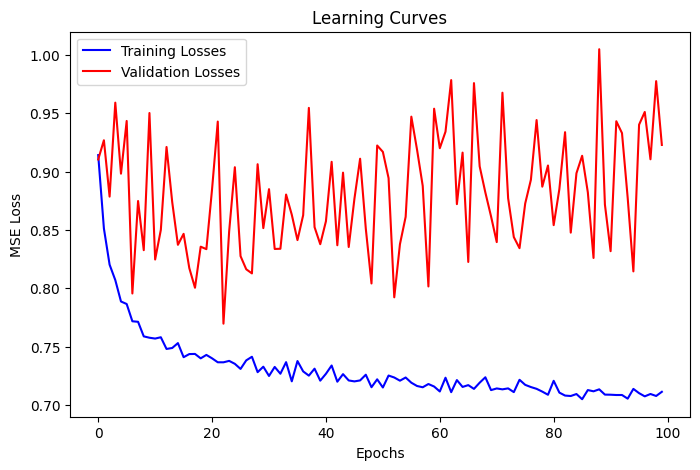

In [17]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(trainer.train_losses, color='blue', label='Training Losses')
ax.plot(trainer.val_losses, color='red', label='Validation Losses')
ax.legend()
ax.set(xlabel='Epochs', ylabel='MSE Loss', title='Learning Curves')
plt.show()

In [18]:
linear_regression_nn_trained = trainer.model

# Fully Connected Neural Network

## Model Definition

In [11]:
class CSOPFullyConnectedNN(nn.Module):
    def __init__(self, num_input_features):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features=num_input_features, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=8),
            nn.ReLU(),
            nn.Linear(in_features=8, out_features=4),
            nn.ReLU(),
            nn.Linear(in_features=4, out_features=1)
        )

    def forward(self, X):
        return self.net(X)

In [12]:
fully_connected_nn = CSOPFullyConnectedNN(num_input_features=X_train.shape[1])

## Model Training Setup

In [13]:
loss_fn = nn.MSELoss()
learning_rate = 0.0001
optimizer = Adam(params=fully_connected_nn.parameters(), lr=learning_rate)
max_epochs = 100

In [14]:
best_mse = float('inf')
best_weights = None
train_losses, val_losses = [], []

## Model Training Loop

In [15]:
for epoch in range(max_epochs):
    # Training for one epoch
    fully_connected_nn.train()
    train_loss = 0
    with tqdm(list(range(len(train_dataloader))), unit="batch", mininterval=0, disable=False) as bar:
        bar.set_description(f'Epoch: {epoch}')
        for (X_batch, y_batch), start in zip(train_dataloader, bar):
            # Forward Pass
            X_batch, y_batch = X_batch.to(torch.float32), y_batch.to(torch.float32)
            y_pred = fully_connected_nn(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # Backward Pass
            optimizer.zero_grad()
            loss.backward()
            # Weights Updates
            optimizer.step()
            # Print Progress
            bar.set_postfix(mse=float(loss))
            train_loss += float(loss)
    # Calculating average training loss after one epoch
    avg_train_mse_loss = float(train_loss/len(train_dataloader))
    train_losses.append(avg_train_mse_loss)
    # Validation after one epoch
    fully_connected_nn.eval()
    val_loss = 0
    for X_batch, y_batch in val_dataloader:
        # Forward Pass
        X_batch, y_batch = X_batch.to(torch.float32), y_batch.to(torch.float32)
        y_pred = fully_connected_nn(X_batch)
        val_mse_loss = loss_fn(y_pred, y_batch)
        val_loss += float(val_mse_loss)
    # Calculating average validation loss after one epoch
    avg_val_mse_loss = float(val_loss/len(val_dataloader))
    val_losses.append(avg_val_mse_loss)
    # Checking if we improved from the previous best epoch
    if avg_val_mse_loss < best_mse:
        best_mse = avg_val_mse_loss
        best_weights = copy.deepcopy(fully_connected_nn.state_dict())

Epoch: 99:  93%|█████████▎| 13/14 [00:00<00:00, 274.68batch/s, mse=0.374]


In [16]:
fully_connected_nn.load_state_dict(best_weights)
model_path = f'feature_bagging_nn_models/fully_connected_nn_best_model'
torch.save(fully_connected_nn.state_dict(), model_path)


Best Validation MSE: 0.8147574216127396


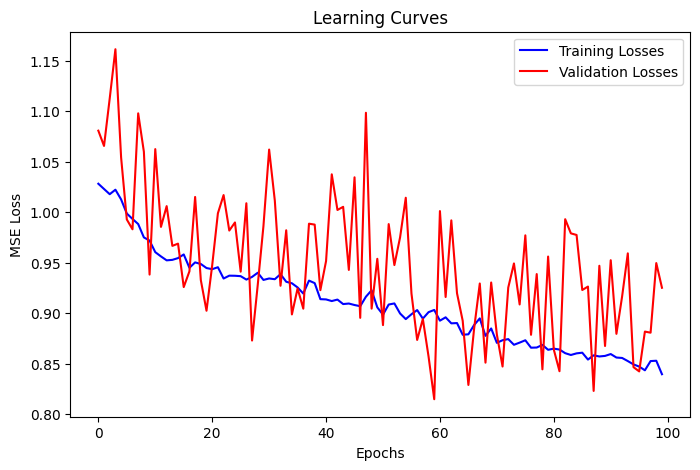

In [17]:
print(f'Best Validation MSE: {best_mse}')
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(train_losses, color='blue', label='Training Losses')
ax.plot(val_losses, color='red', label='Validation Losses')
ax.legend()
ax.set(xlabel='Epochs', ylabel='MSE Loss', title='Learning Curves')
plt.show()

In [27]:
def calc_nn_metrics(y_true, y_pred, type='TRAIN'):
    r2 = r2_score(y_true=y_true, y_pred=y_pred).round(4)
    mse = mean_squared_error(y_true=y_true, y_pred=y_pred).round(4)
    rmse = np.sqrt(mse).round(4)
    mae = mean_absolute_error(y_true=y_true, y_pred=y_pred).round(4)

    print(f'{type} METRICS')
    print(f'R2: {r2}\tMSE: {mse}\tRMSE: {rmse}\tMAE: {mae}')

In [25]:
train_preds = fully_connected_nn(torch.tensor(X_train.to_numpy(), dtype=torch.float32)).detach().numpy()
val_preds = fully_connected_nn(torch.tensor(X_val.to_numpy(), dtype=torch.float32)).detach().numpy()

In [28]:
calc_nn_metrics(y_true=y_train, y_pred=train_preds, type='TRAIN')

TRAIN METRICS
R2: 0.0975	MSE: 0.8913	RMSE: 0.9441	MAE: 0.6666


In [29]:
calc_nn_metrics(y_true=y_val, y_pred=val_preds, type='VALIDATION')

VALIDATION METRICS
R2: 0.1544	MSE: 0.9327	RMSE: 0.9658	MAE: 0.7285
